# Seasonal lags to capture seasonality

In [1]:
import datetime
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context('talk')


## Data set synopsis
The air passengers dataset is the monthly totals of international airline passengers, from 1949 to 1960, in units of 1000s.

For instructions on how to download, prepare, and store the dataset, refer to notebook number 5, in the folder "01-Create-Datasets" from this repo.

## Load data

In [2]:
data = pd.read_csv('../datasets/example_air_passengers.csv',
                   parse_dates=['ds'],
                   index_col=['ds'])

## Plot the data

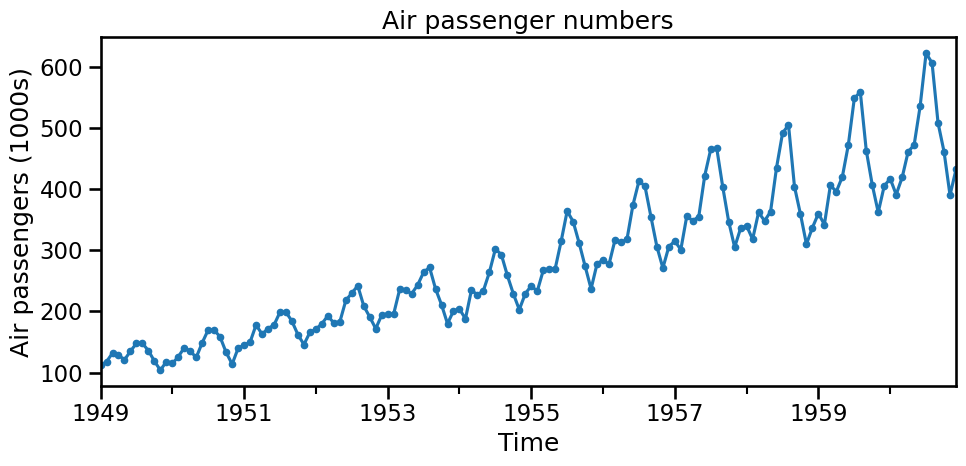

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))
data.plot(y='y', marker='.', figsize=(10, 5), legend=None, ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Air passengers (1000s)')
ax.set_title('Air passenger numbers')
plt.tight_layout()


## Forecasting with seasonal lag features
For this problem we know that there is yearly seasonality. So perhaps using a lag feature of 12 months can help us capture the seasonality. See the Lag features section of the course and the notebooks in `07-Lag-Features` for more information around using the various methods to identify potential seasonal lags when we don't know what seasonality to use.

Let's build a recursive forecast and see how we can include lag features in our feature engineering pipeline.

In [4]:
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import clone

from sklearn import set_config
set_config(transform_output='pandas')

In [5]:
df = data.copy()

In [6]:
target = ['y']

In [7]:
# polynomial time features for trend
time_feats = make_pipeline(
    TimeSince(),
    PolynomialFeatures(degree=2, include_bias=False)
)

# lag and window features
lag_window_feats = WindowSummarizer(
    lag_feature={
        'lag': [1, 12],
    },
    target_cols=target,
    truncate='bfill'
)

Create a pipeline to create all our features

In [8]:
pipeline = make_union(
    time_feats,
    lag_window_feats
)

# apply min max scaling to all the features
pipeline = make_pipeline(pipeline, MinMaxScaler())

In [9]:
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince()),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(include_bias=False))])),
                                                ('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'lag': [1, 12]}, target_cols=['y'],
                 truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler())])

In [10]:
pipeline.fit_transform(df.head(25))

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\summarize.py:299: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 12]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  func_dict.loc[:, "window"] = func_dict["window"].astype("object")


,time_since_1949-01-01 00:00:00,time_since_1949-01-01 00:00:00^2,y_lag_1,y_lag_12
ds,,,,
1949-01-01,0.000000,0.000000,0.121212,0.181818
1949-02-01,0.041667,0.001736,0.121212,0.181818
1949-03-01,0.083333,0.006944,0.212121,0.181818
1949-04-01,0.125000,0.015625,0.424242,0.181818
1949-05-01,0.166667,0.027778,0.378788,0.181818
1949-06-01,0.208333,0.043403,0.257576,0.181818
1949-07-01,0.250000,0.062500,0.469697,0.181818
1949-08-01,0.291667,0.085069,0.666667,0.181818
1949-09-01,0.333333,0.111111,0.666667,0.181818


In [11]:
# we can use clone to return an unfitted version
pipeline = clone(pipeline)

Let's build a recursive forecast.

We'll start with configuring the model, the forecast start time, the number of steps to forecast, etc.

In [12]:
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

In [13]:
# CONFIG
forecast_start_time = df.index.max() - pd.DateOffset(months=36)    # start 3 years from the end
num_of_forecast_steps = 12 * 3

# define the model
model = LGBMRegressor()

# create a list of periods that we'll forecast over
forecast_horizon = pd.date_range(
    forecast_start_time, periods=num_of_forecast_steps, freq='MS'
)

# how much data in the past is needed to create our features
look_back_window_size = pd.DateOffset(months=12)

In [14]:
# CREATE TRAINING AND TESTING DF
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

In [15]:
# FEATURE ENGINEERING
y_train = df_train[target]
X_train = pipeline.fit_transform(df_train)

# LightGBM cannot handle column names which have certain characters
# we replace these with _
if 'lightgbm' in model.__module__:
    X_train = X_train.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "_", x))

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\summarize.py:299: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 12]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  func_dict.loc[:, "window"] = func_dict["window"].astype("object")


In [16]:
# MODEL TRAINING
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 139
[LightGBM] [Info] Number of data points in the train set: 107, number of used features: 4
[LightGBM] [Info] Start training from score 229.915888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMRegressor()

In [17]:
# CREATE DYNAMIC PREDICTION DATAFRAME
look_back_start_time = forecast_start_time - look_back_window_size

# create df_predict which has data going as far back as needed
# to create features which need past values
df_predict = df_train.loc[look_back_start_time:].copy()

# extend index into forecast horizon
df_predict = pd.concat([df_predict, pd.DataFrame(index=forecast_horizon)])

In [18]:
# RECURSIVE FORECASTING LOOP
for forecast_time in forecast_horizon:
    X_test_ = pipeline.transform(df_predict)
    X_test = X_test_.loc[[forecast_time]]

    # predict one step ahead
    y_pred = model.predict(X_test)

    # append forecast to the target variable column in df_predict
    # this df_predct is ready for the next iteration where we will recompute features
    # derived from the target
    df_predict.loc[[forecast_time], target] = y_pred

In [19]:
# GET FORECAST AND TEST VALUES
y_forecast = df_predict.loc[forecast_horizon, target]
y_test = df_test.loc[forecast_start_time:, target]

In [20]:
# CREATE IN-SAMPLE PREDICTIONS
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

Text(0.5, 1.0, 'Recursive forecast with LGBMRegressor()')

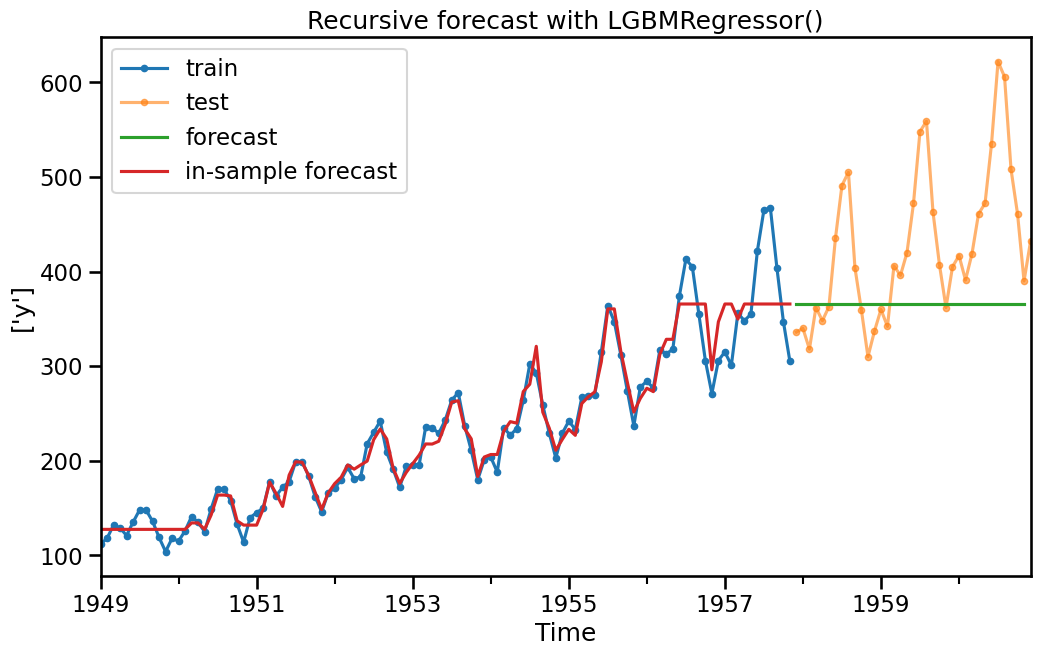

In [21]:
# PLOTTING
fig, ax = plt.subplots(figsize=(12, 7))

# plot training set
y_train.plot(ax=ax, marker='.')
# plot actuals in forecasting horizon
y_test.plot(ax=ax, marker='.', alpha=.6)
# plot forecast
y_forecast.plot(ax=ax)
# plot 1 step forecast in training data
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlabel("Time")
ax.set_ylabel(f"{target}")
ax.set_title(f"Recursive forecast with {model}")

In [22]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(
    y_true=y_test.loc[y_forecast.index],
    y_pred = y_forecast
)

99.80871638039856